# Cortex n_HVG Analysis

This notebook analyzes the impact of the numer of HVGs on CarDEC results using the Cortex Data.

I evaluate CarDEC's robustness to the number of HVGs selected. To do this, I pick the bottom 21215 - 5000 = 16215 genes by variability, and I measure the ARI of a louvain clustering on these genes after correcting them using CarDEC, with the number of HVGs selected for CarDEC varing from 500 to 5000 genes.

In [2]:
"""Miscellaneous useful functions"""

def read_cortex(path):
    adata = AnnData(mmread(os.path.join(path, "count.umis.txt"))).T
    urls_ = ["meta_combined.txt", "genes.txt", "cell.names.new.txt"]
    urls_ = [os.path.join(path, x) for x in urls_]
    metadata, genes, cells = [pd.read_csv(url_, sep = '\t') for url_ in urls_]
    genes, cells = list(genes['scientific']), list(cells['cellname'])
    indices = [x in list(metadata["NAME"]) for x in cells]
    adata.obs.index, adata.var.index = cells, genes
    adata.X = adata.X.toarray()
    adata = adata[indices]
    adata.obs = metadata
    
    sc.pp.filter_cells(adata, min_genes = 200)
    sc.pp.filter_genes(adata, min_cells = 30)
    
    adata = adata[adata.obs["CellType"].values != "Unassigned"]
    print(adata)
    
    return(adata)

def purity_score(y_true, y_pred):
    """A function to compute cluster purity"""
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)

    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

def convert_string_to_encoding(string, vector_key):
    """A function to convert a string to a numeric encoding"""
    return np.argwhere(vector_key == string)[0][0]

def convert_vector_to_encoding(vector):
    """A function to convert a vector of strings to a dense numeric encoding"""
    vector_key = np.unique(vector)
    vector_strings = list(vector)
    vector_num = [convert_string_to_encoding(string, vector_key) for string in vector_strings]
    
    return vector_num

def build_dir(dir_path):
    subdirs = [dir_path]
    substring = dir_path

    while substring != '':
        splt_dir = os.path.split(substring)
        substring = splt_dir[0]
        subdirs.append(substring)
        
    subdirs.pop()
    subdirs = [x for x in subdirs if os.path.basename(x) != '..']

    n = len(subdirs)
    subdirs = [subdirs[n - 1 - x] for x in range(n)]
    
    for dir_ in subdirs:
        if not os.path.isdir(dir_):
            os.mkdir(dir_)
            
def save_umaps(adata, colors, path):
    build_dir(path)
    
    print(" ")
    for color in colors:
        filename = color + ".png"
        savepath = os.path.join(path, filename)
        
        sc.pl.umap(adata, color = [color], show = False, save = filename)
        saved_name = "figures/umap" + filename
        move(saved_name, savepath)
        
    print(" ")
    os.rmdir("figures")
    
def find_resolution(adata_, n_clusters, random = 0): 
    adata = adata_.copy()
    obtained_clusters = -1
    iteration = 0
    resolutions = [0., 1000.]
    
    while obtained_clusters != n_clusters and iteration < 50:
        current_res = sum(resolutions)/2
        sc.tl.louvain(adata, resolution = current_res, random_state = random)
        labels = adata.obs['louvain']
        obtained_clusters = len(np.unique(labels))
        
        if obtained_clusters < n_clusters:
            resolutions[0] = current_res
        else:
            resolutions[1] = current_res
        
        iteration = iteration + 1
        
    return current_res

save_allumaps = False

metrics_ = [ari, nmi, purity_score]

Now, let's read the data in, and take a look at the cell type distribution.

View of AnnData object with n_obs × n_vars = 28426 × 17295
    obs: 'NAME', 'nGene', 'nUMI', 'percent.mito', 'Cluster', 'CellType', 'Experiment', 'Method', 'n_genes'
    var: 'n_cells'


/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


The number of cells of type: B cell is 4773
The number of cells of type: CD14+ monocyte is 4896
The number of cells of type: CD16+ monocyte is 777
The number of cells of type: CD4+ T cell is 7188
The number of cells of type: Cytotoxic T cell is 8504
The number of cells of type: Dendritic cell is 411
The number of cells of type: Megakaryocyte is 202
The number of cells of type: Natural killer cell is 1515
The number of cells of type: Plasmacytoid dendritic cell is 160


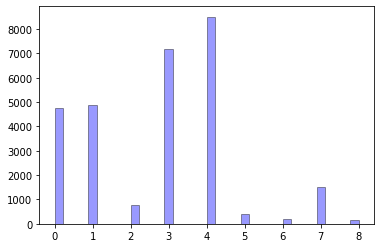

In [3]:
adata = read_pbmc("../Data/cortex", cache = True)

celltype = adata.obs['CellType'].values
celltype_vec = convert_vector_to_encoding(celltype)

sns.distplot(celltype_vec, hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

celltype_key = np.unique(adata.obs['CellType'].values)
for type_ in celltype_key:
    ntype = sum([x == type_ for x in celltype])
    print("The number of cells of type: " + type_ + " is " + str(ntype))

In [7]:
HVG_set = [500 * i for i in range(10, 0, -1)]
ARIs = pd.Series(np.zeros((len(HVG_set),), dtype = 'float32'), index = HVG_set)

In [8]:
for n_HVG in HVG_set:
    CarDEC = CarDEC_API(adata, weights_dir = "PBMC nHVG Eval/HVG Number_" + str(n_HVG), batch_key = 'Method', n_high_var = n_HVG)
    CarDEC.build_model(n_clusters = 6)
    CarDEC.make_inference()

    if n_HVG == HVG_set[0]:
        common_genes = CarDEC.dataset.var.index[CarDEC.dataset.var['Variance Type'] == 'LVG']

    temporary = AnnData(deepcopy(CarDEC.dataset[:, common_genes].layers['denoised']))
    temporary.obs = CarDEC.dataset.obs
    temporary.obs['cell_type'] = temporary.obs['CellType']

    sc.tl.pca(temporary, svd_solver = 'arpack')
    sc.pp.neighbors(temporary, n_neighbors = 15)

    print(temporary.shape)
    res = find_resolution(temporary, 6)
    sc.tl.louvain(temporary, resolution = res)
    temporary.obs['cluster assignment 6'] = temporary.obs['louvain']
    
    ARIs[n_HVG] = ari(temporary.obs['CellType'], temporary.obs['cluster assignment 6'])

... storing 'Variance Type' as categorical
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Pretrain weight index file detected, loading weights.
Pretrained high variance autoencoder weights initialized.

-----------------------CarDEC Architecture-----------------------

Model: "car_dec__model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 32)                644256    
_________________________________________________________________
decoder (Sequential)         (None, 5000)              649224    
_________________________________________________________________
encoderLVG (Sequential)      (1, 32)                   1578016   
_________________________________________________________________
decoderLVG (Sequential)      (1, 12295)                1594375   
_________________________________________________________________
clustering (ClusteringLayer) multiple                  192       
Total params: 4,466,063
Trainable params: 4,466,063
Non-trainable para

... storing 'Variance Type' as categorical
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Pretrain weight index file detected, loading weights.
Pretrained high variance autoencoder weights initialized.

-----------------------CarDEC Architecture-----------------------

Model: "car_dec__model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 32)                580256    
_________________________________________________________________
decoder (Sequential)         (None, 4500)              584724    
_________________________________________________________________
encoderLVG (Sequential)      (1, 32)                   1642016   
_________________________________________________________________
decoderLVG (Sequential)      (1, 12795)                1658875   
_________________________________________________________________
clustering (ClusteringLayer) multiple                  192       
Total params: 4,466,063
Trainable params: 4,466,063
Non-trainable para

... storing 'Variance Type' as categorical
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Pretrain weight index file detected, loading weights.
Pretrained high variance autoencoder weights initialized.

-----------------------CarDEC Architecture-----------------------

Model: "car_dec__model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 32)                516256    
_________________________________________________________________
decoder (Sequential)         (None, 4000)              520224    
_________________________________________________________________
encoderLVG (Sequential)      (1, 32)                   1706016   
_________________________________________________________________
decoderLVG (Sequential)      (1, 13295)                1723375   
_________________________________________________________________
clustering (ClusteringLayer) multiple                  192       
Total params: 4,466,063
Trainable params: 4,466,063
Non-trainable para

... storing 'Variance Type' as categorical
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Pretrain weight index file detected, loading weights.
Pretrained high variance autoencoder weights initialized.

-----------------------CarDEC Architecture-----------------------

Model: "car_dec__model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 32)                452256    
_________________________________________________________________
decoder (Sequential)         (None, 3500)              455724    
_________________________________________________________________
encoderLVG (Sequential)      (1, 32)                   1770016   
_________________________________________________________________
decoderLVG (Sequential)      (1, 13795)                1787875   
_________________________________________________________________
clustering (ClusteringLayer) multiple                  192       
Total params: 4,466,063
Trainable params: 4,466,063
Non-trainable para

... storing 'Variance Type' as categorical
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Pretrain weight index file detected, loading weights.
Pretrained high variance autoencoder weights initialized.

-----------------------CarDEC Architecture-----------------------

Model: "car_dec__model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 32)                388256    
_________________________________________________________________
decoder (Sequential)         (None, 3000)              391224    
_________________________________________________________________
encoderLVG (Sequential)      (1, 32)                   1834016   
_________________________________________________________________
decoderLVG (Sequential)      (1, 14295)                1852375   
_________________________________________________________________
clustering (ClusteringLayer) multiple                  192       
Total params: 4,466,063
Trainable params: 4,466,063
Non-trainable para

... storing 'Variance Type' as categorical
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Pretrain weight index file detected, loading weights.
Pretrained high variance autoencoder weights initialized.

-----------------------CarDEC Architecture-----------------------

Model: "car_dec__model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 32)                324256    
_________________________________________________________________
decoder (Sequential)         (None, 2500)              326724    
_________________________________________________________________
encoderLVG (Sequential)      (1, 32)                   1898016   
_________________________________________________________________
decoderLVG (Sequential)      (1, 14795)                1916875   
_________________________________________________________________
clustering (ClusteringLayer) multiple                  192       
Total params: 4,466,063
Trainable params: 4,466,063
Non-trainable para

... storing 'Variance Type' as categorical
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Pretrain weight index file detected, loading weights.
Pretrained high variance autoencoder weights initialized.

-----------------------CarDEC Architecture-----------------------

Model: "car_dec__model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 32)                260256    
_________________________________________________________________
decoder (Sequential)         (None, 2000)              262224    
_________________________________________________________________
encoderLVG (Sequential)      (1, 32)                   1962016   
_________________________________________________________________
decoderLVG (Sequential)      (1, 15295)                1981375   
_________________________________________________________________
clustering (ClusteringLayer) multiple                  192       
Total params: 4,466,063
Trainable params: 4,466,063
Non-trainable para

... storing 'Variance Type' as categorical
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Pretrain weight index file detected, loading weights.
Pretrained high variance autoencoder weights initialized.

-----------------------CarDEC Architecture-----------------------

Model: "car_dec__model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 32)                196256    
_________________________________________________________________
decoder (Sequential)         (None, 1500)              197724    
_________________________________________________________________
encoderLVG (Sequential)      (1, 32)                   2026016   
_________________________________________________________________
decoderLVG (Sequential)      (1, 15795)                2045875   
_________________________________________________________________
clustering (ClusteringLayer) multiple                  192       
Total params: 4,466,063
Trainable params: 4,466,063
Non-trainable para

... storing 'Variance Type' as categorical
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Pretrain weight index file detected, loading weights.
Pretrained high variance autoencoder weights initialized.

-----------------------CarDEC Architecture-----------------------

Model: "car_dec__model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 32)                132256    
_________________________________________________________________
decoder (Sequential)         (None, 1000)              133224    
_________________________________________________________________
encoderLVG (Sequential)      (1, 32)                   2090016   
_________________________________________________________________
decoderLVG (Sequential)      (1, 16295)                2110375   
_________________________________________________________________
clustering (ClusteringLayer) multiple                  192       
Total params: 4,466,063
Trainable params: 4,466,063
Non-trainable para

... storing 'Variance Type' as categorical
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Pretrain weight index file detected, loading weights.
Pretrained high variance autoencoder weights initialized.

-----------------------CarDEC Architecture-----------------------

Model: "car_dec__model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 32)                68256     
_________________________________________________________________
decoder (Sequential)         (None, 500)               68724     
_________________________________________________________________
encoderLVG (Sequential)      (1, 32)                   2154016   
_________________________________________________________________
decoderLVG (Sequential)      (1, 16795)                2174875   
_________________________________________________________________
clustering (ClusteringLayer) multiple                  192       
Total params: 4,466,063
Trainable params: 4,466,063
Non-trainable para

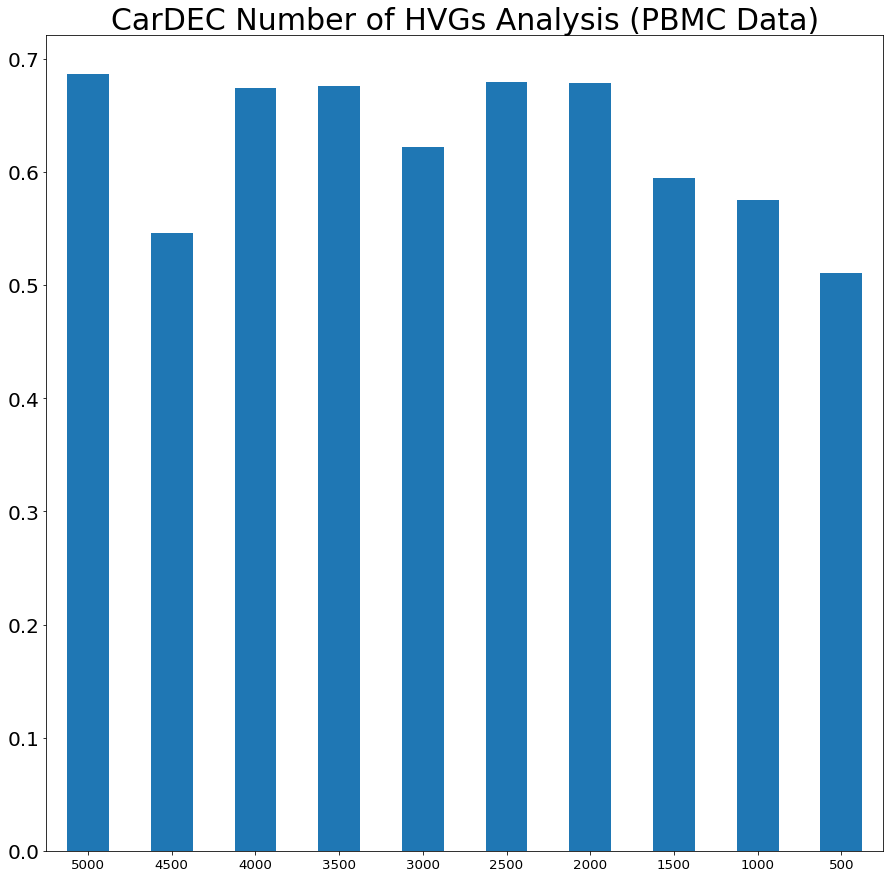

In [9]:
from matplotlib import pyplot

f = 20
pyplot.rc('xtick', labelsize = f/1.5)    # fontsize of the tick labels
pyplot.rc('ytick', labelsize = f)    # fontsize of the tick labels

ax = ARIs.T.plot.bar(rot = 0, figsize = (15 , 15))
ax.set_title("CarDEC Number of HVGs Analysis (Cortex Data)", size = 30)

"""Figure info for paper"""
base_path = "../Figures/cortex_revisions"
build_dir(base_path)

path = os.path.join(base_path, 'nHVG_analysis_cortex')

ax = ax.get_figure()
ax.savefig(path + '.png', dpi=300)
im = Image.open(path + '.png')
im.save(path + '.tiff')